### Rappel Google Colab

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator. 
Installer ensuite deeplib avec la commande suivante:

In [ ]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

# Laboratoire 3: Optimisation

## 1. Fonctions d'optimisation

Dans cette section, vous testerez différentes fonctions d'optimisation et observerez leurs effets sur l'entraînement.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import poutyne as pt

from deeplib.history import History
from deeplib.datasets import train_valid_loaders, load_cifar10

from torchvision.transforms import ToTensor

from deeplib.net import CifarNet

from deeplib.training import train, validate_ranking, test
from deeplib.visualization import show_worst, show_random, show_best

### 1.1 Un exemple jouet

On va commencer par explorer les effets des variantes de SGD avec un exemple jouet. L'exemple jouet va consister en une régression linéaire simple en 2 dimensions avec laquelle on sera en mesure de visualiser l'impact des différents variantes de SGD. En effet, dans cette section, on va joué avec trois paramètres de SGD: le taux d'apprentissage, le momentum et l'accélération de Nesterov.

La cellule ci-dessous crée des fonctions qui vont nous permettre de visualiser l'entraîenement.

In [2]:
def show_2d_function(fct, min_val=-5, max_val=5, mesh_step=.01, optimal=None, bar=True, ax=None, **kwargs):
    """
    Trace les courbes de niveau d'une fonction 2D.
    
    Args:
        fct: Fonction objective qui prend en paramètre un tenseur Nx2 correspondant à 
            N paramètres pour lesquels on veut obtenir la valeur de la fonction.
        optimal: La valeur optimale des poids pour la fonction objective.
    """
    w1_values = torch.arange(min_val, max_val+mesh_step, mesh_step)
    w2_values = torch.arange(min_val, max_val+mesh_step, mesh_step)
    
    w2, w1 = torch.meshgrid(w2_values, w1_values)
    w_grid = torch.stack((w1.flatten(), w2.flatten()))
    fct_values = fct(w_grid).view(w1_values.shape[0], w2.shape[0]).numpy()
    
    if ax is not None:
        plt.sca(ax)
    if 'cmap' not in kwargs: kwargs['cmap'] = 'RdBu'
    plt.contour(w1_values, w2_values, fct_values, 40, **kwargs)
    plt.xlim((min_val, max_val))
    plt.ylim((min_val, max_val))
    plt.xlabel('$w_1$')
    plt.ylabel('$w_1$')
    
    if bar:
        plt.colorbar()
        
    if optimal is not None: 
        plt.scatter(*optimal, s=200, marker='*', c='r')

def show_2d_trajectory(w_history, fct, min_val=-5, max_val=5, mesh_step=.5, optimal=None, ax=None):
    """
    Trace le graphique de la trajectoire de descente en gradient en 2D.
    
    Args:
        w_history: L'historique de la valeur des poids lors de l'entraînement.
        fct: Fonction objective qui prend en paramètre un tenseur Nx2 correspondant à 
            N paramètres pour lesquels on veut obtenir la valeur de la fonction.
        optimal: La valeur optimale des poids pour la fonction objective.
    """
    show_2d_function(fct, min_val, max_val, mesh_step, optimal=optimal, ax=ax) 
    
    if len(w_history) > 0:
        trajectory = np.array(w_history)
        plt.plot(trajectory[:,0], trajectory[:,1], 'o--', c='g')
    
    plt.title('Trajectoire de la descente en gradient'); plt.xlabel('$w_1$'); plt.ylabel('$w_2$')
    
def show_learning_curve(loss_list, loss_opt=None, ax=None):
    """
    Trace le graphique des valeurs de la fonction objective lors de l'apprentissage.
    
    Args:
        loss_list: L'historique de la valeur de la perte lors de l'entraînement.
        loss_opt: La valeur optimale de perte.
    """
    if ax is not None:
        plt.sca(ax)
    plt.plot(np.arange(1, len(loss_list) + 1), loss_list, 'o--', c='g', label='$F(\mathbf{w})$')
    if loss_opt is not None: plt.plot([1, len(loss_list)], 2*[loss_opt], '*--', c='r', label='optimal');
    plt.title('Valeurs de la fonction objectif'); plt.xlabel('$t$')
    plt.legend()

Initialisations notre jeu de données jouet qui va contenir seulement 3 points en 2 dimensions ainsi que 3 valeurs à régresser.

In [3]:
x = torch.tensor([[1,1],[0,-1],[2,.5]], dtype=torch.float32)
y = torch.tensor([[-1.], [3], [2]], dtype=torch.float32)

Lors d'une régression linéaire, on souhaite trouver des poids $w^*$ qui minimise pour chaque exemple $(x_i, y_i)$ la perte quadratique entre $x_i \cdot w$ et $y_i$. Mathématiquement, voici la fonction que l'on souhaite optimiser:
$$w^* = \text{argmin}_w \frac{1}{n} \sum_{i=1}^{n} (x_i \cdot w - y_i)^2$$
La cellule ci-dessous est cette fonction objective en fonction des paramètres $w$ que l'on souhaite trouver.

In [4]:
def objective_function(w):
    return torch.mean((x @ w - y) ** 2, dim=0)

Comme vous vous en rappelez peut-être, la solution d'une régression linéaire a une forme analytique qui est la suivante.
$$w^* = (X^TX)^{-1}X^TY$$
La cellule ci-dessous trouve la solution pour notre problème jouet en utilisant cette formule.

In [5]:
w_opt = torch.inverse(x.T @ x) @ x.T @ y

Avec une des fonctions définie plus haut, visualisons maintenant notre fonction objective avec des courbes de niveau. Les deux axes correspondent à différentes valeurs pour les 2 poids respectifs de $w$ pour notre régression linéaire en 2 dimensions. La couleur des courbes de niveau donne la valeur de la fonction objective. L'étoile rouge correspond à $w^*$, notre valeur optimale des poids.

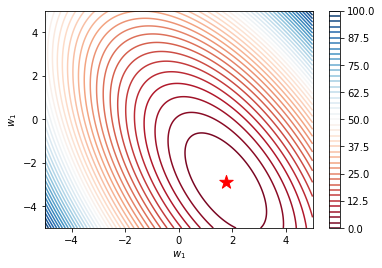

In [6]:
show_2d_function(objective_function, optimal=w_opt)

Les prochaines cellules définissent deux fonctions. 

La première fonction se charge d'optimiser notre fonction objective à la manière des réseaux de neurones en utilisant l'optimiseur SGD de PyTorch. Des commentaires dans cette fonction ont été laissés afin que vous puissez comprendre le déroulement de l'optimisation.

In [7]:
def optimize(learning_rate, momentum, nesterov, nb_iter=20):
    """
    Optimise la fonction objective à la manière de PyTorch avec l'optimiseur SGD.
    
    Args:
        learning_rate: Le taux d'apprentissage.
        momentum: La valeur du momentum.
        nesterov: Si l'accélération de Nesterov est désirée.
        nb_iter: Le nombre d'itérations effectué.
    
    Returns:
        Tuple `(w_history, loss_history)` où `w_history` correspond à 
        l'historique des poids lors de l'optimisation et `loss_history`
        correspond à l'historique de la valeur de la fonction objective 
        ou fonction de perte dans le cadre des réseaux de neurones.
    """
    torch.manual_seed(42)
    
    # Notre réseau: une couche linéaire sans biais. Essentiellement, 2 poids.
    neuron = nn.Linear(2, 1, bias=False)
    
    # La fonction de perte quadratique.
    loss_function = nn.MSELoss()
    
    # Initialise l'optimiseur SGD
    optimizer = optim.SGD(neuron.parameters(), lr=learning_rate, momentum=momentum, nesterov=nesterov)

    # À la différence des réseaux de neurones, on ne divise pas en epochs
    # et en batchs étant donné que notre jeu de données contient seulement
    # 3 points et que notre problème est convexe et donc résoluble avec une
    # simple descente de gradient. On fera donc un certain nombre d'itérations
    # pour trouver la solution du problème. Pour chaque itération, on y va à 
    # la manière des réseaux de neurones:
    # - On effectue une prédiction;
    # - On calcule notre perte;
    # - On fait la rétropropagation (backpropagation) via la méthode backward();
    # - On met à jour les poids avec l'optimiseur.
    w_history = []
    loss_history = []
    for t in range(nb_iter):
        y_pred = neuron(x)
        loss = loss_function(y_pred, y)         
        w_history.append(neuron.weight.squeeze(0).detach().clone().numpy())
        loss_history.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    return w_history, loss_history

La deuxième fonction trace des graphiques permettant de visualiser l'optimisation effectuée par la première fonction. 

In [8]:
def show_optimization(w_history, loss_history, title=None):
    """
    Trace deux graphiques montrant le trajet de l'optimisation. Le premier
    montre la valeur des poids lors de l'optimisation. Le deuxième montre 
    la valeur de la perte lors de l'optimisation.
    
    Args:
        w_history: L'historique des poids lors de l'optimisation
        loss_history: L'historique de la valeur de la fonction perte.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14.5, 4))
    if title is not None:
        fig.suptitle(title)
    show_2d_trajectory(w_history, objective_function, optimal=w_opt, ax=axes[0])
    show_learning_curve(loss_history, loss_opt=objective_function(w_opt), ax=axes[1])

On va utiliser ces deux fonctions pour pouvoir visualiser l'impact de trois paramètres de SGD: le taux d'apprentissage, le momentum et l'accélération de Nesterov.

In [9]:
learning_rate = 0.3
momentum = 0
nesterov = False

Optimisons maintenant notre fonction avec les valeurs ci-dessus.

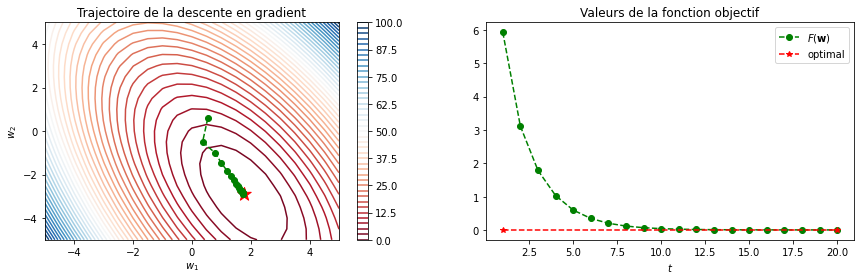

In [10]:
w_history, loss_history = optimize(learning_rate, momentum, nesterov)
show_optimization(w_history, loss_history)

On voit qu'après 10 itérations, l'optimisation a relativement convergé.

#### Exercice

Pour les exercices ci-dessous, vous pouvez utiliser des fonctions comme [`numpy.linspace`](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) ou [`numpy.logspace`](https://numpy.org/doc/stable/reference/generated/numpy.logspace.html) permettant d'obtenir une liste de valeurs à tester.

- Testez différentes valeurs entre 0 et 1 du taux d'apprentissage en complétant la cellule ci-dessous.

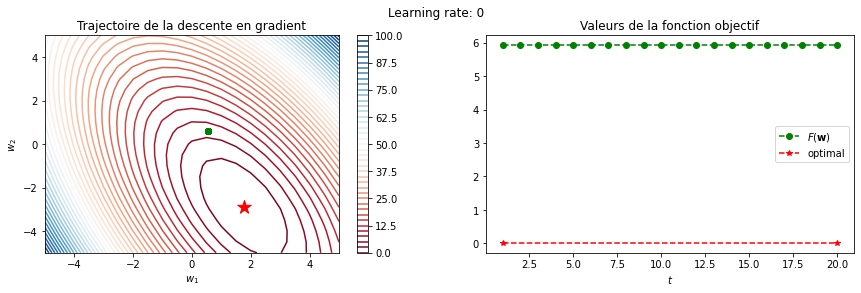

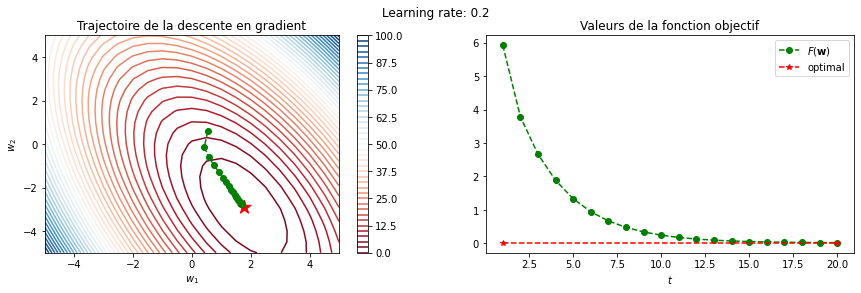

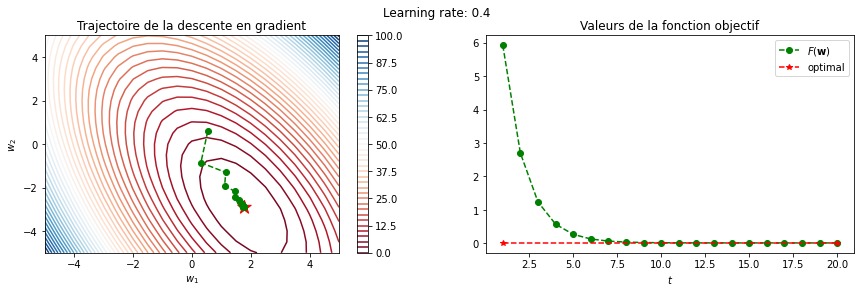

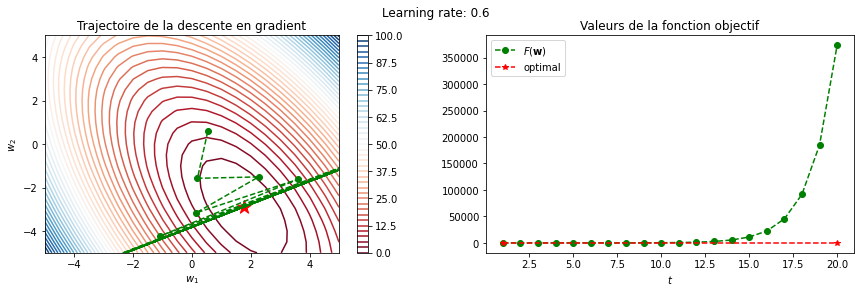

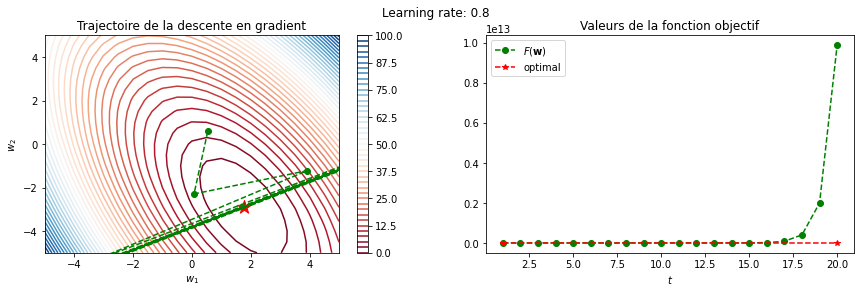

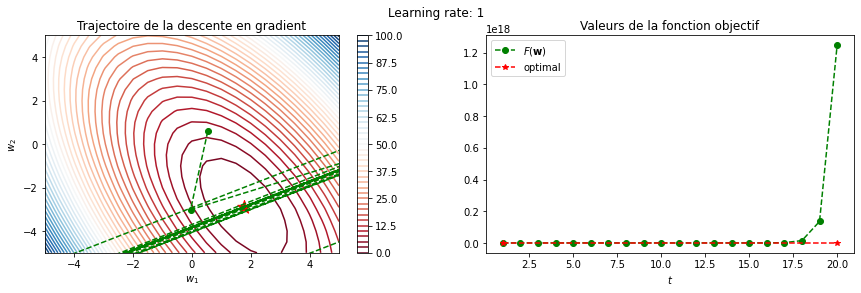

In [11]:
momentum = 0.
nesterov = False
#for learning_rate in [...]: # TODO à compléter avec différentes valeurs
for learning_rate in np.linspace(0., 1., 6):
    w_history, loss_history = optimize(learning_rate, momentum, nesterov)
    show_optimization(w_history, loss_history, title=f"Learning rate: {learning_rate:.2g}")

- Testez différentes valeurs entre 0 et 1 pour le momentum en complétant la cellule ci-dessous.

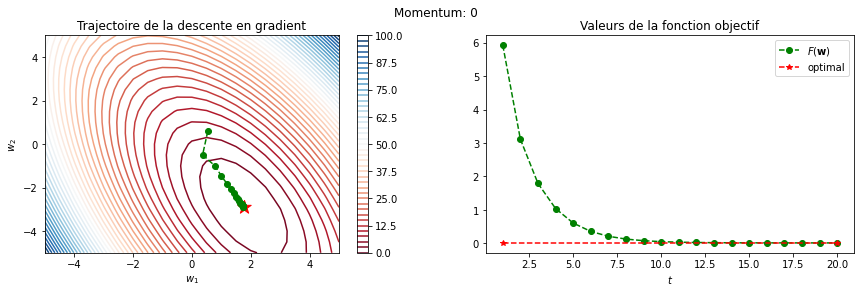

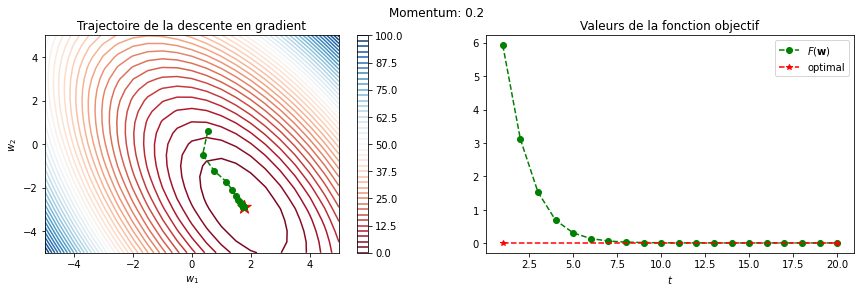

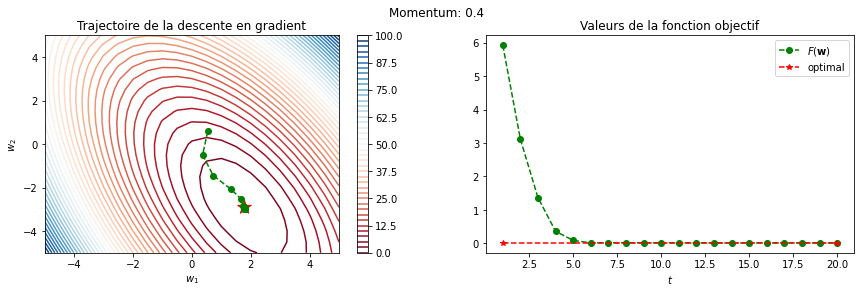

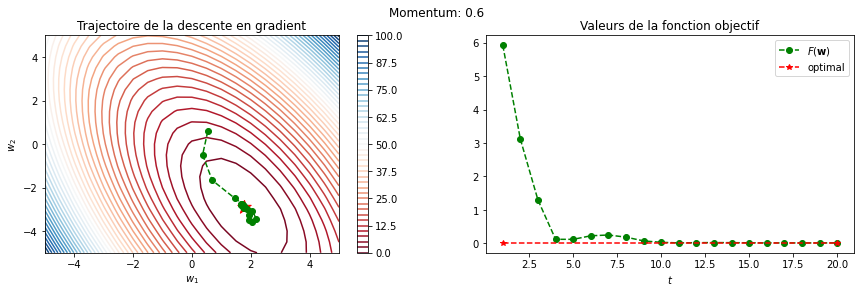

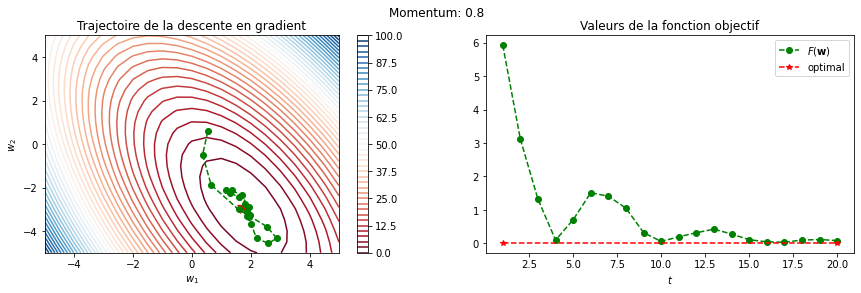

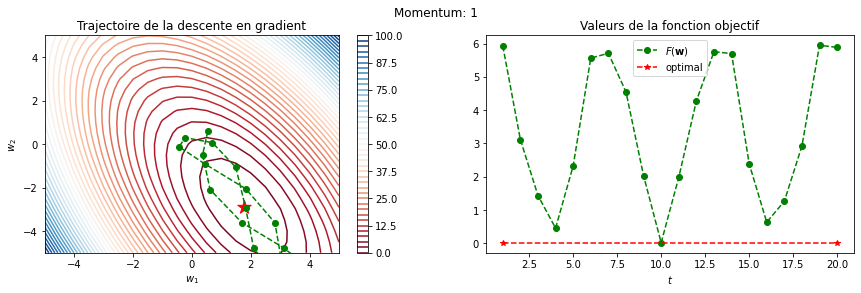

In [12]:
learning_rate = 0.3
nesterov = False
#for momentum in [...]: # TODO à compléter avec différentes valeurs
for momentum in np.linspace(0., 1., 6):
    w_history, loss_history = optimize(learning_rate, momentum, nesterov)
    show_optimization(w_history, loss_history, title=f"Momentum: {momentum:.2g}")

- Testez différentes valeurs entre 0 et 1 pour le momentum avec l'accélération de Nesterov en complétant la cellule ci-dessous.

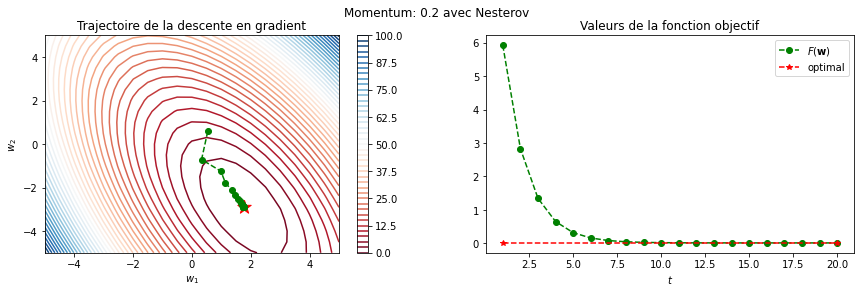

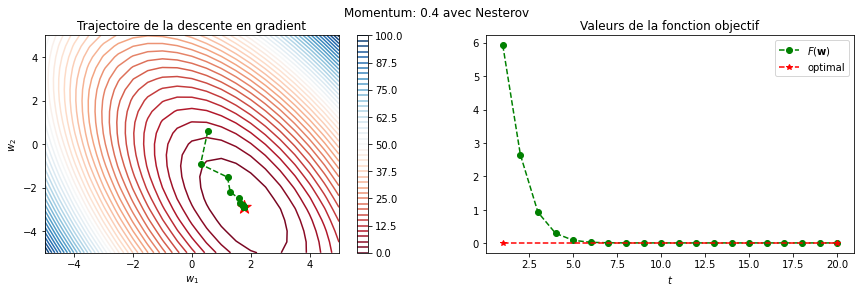

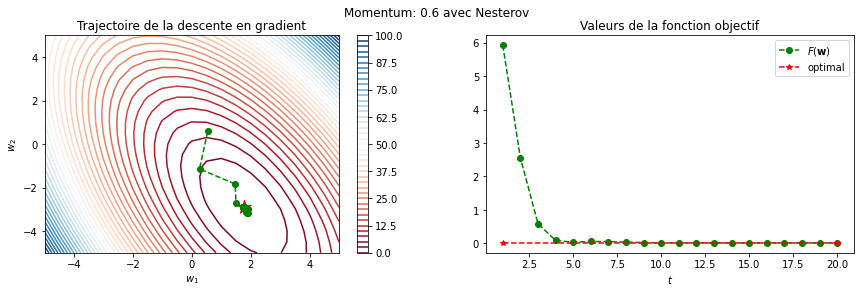

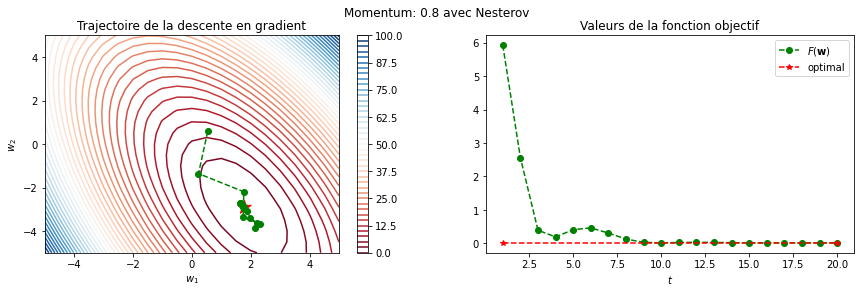

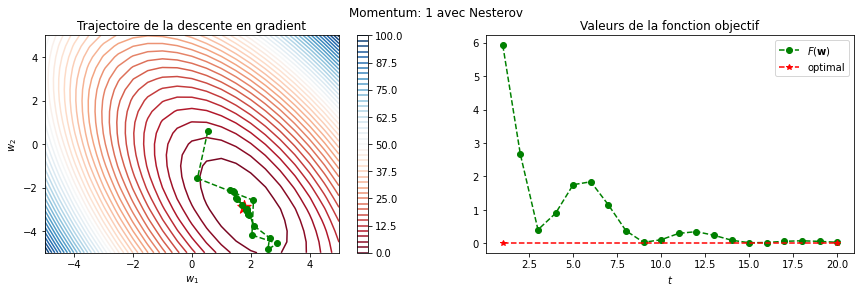

In [13]:
learning_rate = 0.3
nesterov = True
#for momentum in [...]: # TODO à compléter avec différentes valeurs
for momentum in np.linspace(0.2, 1., 5):
    w_history, loss_history = optimize(learning_rate, momentum, nesterov)
    show_optimization(w_history, loss_history, title=f"Momentum: {momentum:.2g} avec Nesterov")

#### Questions
- Que pouvons nous remarquer sur l'impact du taux d'apprentissage sur l'optimisation? **Si le taux d'apprentissage est trop petit ou trop grand, l'apprentissage ne se fera pas. Dans ce cas, on est dans un régime de sous-apprentissage (*underfiting*). Lorsque le taux est trop petit, les poids ne bougent pas suffisamment dans l'espace des poids pour obtenir une bonne solution. Si le taux est trop grand, les poids vont diverger complètement. Également, si le taux n'est ni trop petit ni trop grand, la vitesse de convergence va changer en fonction du taux.**
- Que pouvons nous remarquer sur l'impact du momentum sur l'optimisation? **Dans la solution donnée ici, on remarque qu'avec un momentum de 0.6, on est capable d'être assez près de l'optimal en seulement 3 itérations. Autrement, un momentum plus petit prend plus de temps à converger. Un momentum trop grand va sans cesse diverger pour reconverger par la suite par la nature du momentum.**
- Que pouvons nous remarquer sur l'impact de l'accélération de Nesterov sur l'optimisation? **On remarque que l'accélération de Nesterov tempère de beaucoup le momentum. Même avec une valeur de 1, l'accélération de Nesterov permet de converger alors que ce n'était pas le cas sans l'accélération de Nesterov.**

### 1.2 Un exemple plus près de la réalité

Testons maintenant différents optimiseurs sur un vrai réseau de neurones avec un vrai jeu de données. Comme dans les labos précédents, on utilise le jeu de données CIFAR10 avec un simple réseau à convolution.

Initialisons le jeu de données et quelques hyperparamètres qui vont rester constants.

In [14]:
cifar_train, cifar_test = load_cifar10()

Files already downloaded and verified
Files already downloaded and verified


In [15]:
batch_size = 128
lr = 0.01
n_epoch = 10

#### Exercice

Comparez trois différentes stratégies d'optimisation:
1. [SGD](http://pytorch.org/docs/master/optim.html#torch.optim.SGD)
2. SGD + Momentum accéléré de Nesterov
3. [Adam](http://pytorch.org/docs/master/optim.html#torch.optim.Adam)

Commençons par l'entraîner avec SGD (sans momentum ni accélération de Nesterov).

Epoch: 1/10 Step: 313/313 100.00% |█████████████████████████|5.77s loss: 2.297408 acc: 13.407500 val_loss: 2.289125 val_acc: 17.960000
Epoch: 2/10 Step: 313/313 100.00% |█████████████████████████|5.76s loss: 2.232460 acc: 21.815000 val_loss: 2.093899 val_acc: 24.370000
Epoch: 3/10 Step: 313/313 100.00% |█████████████████████████|5.75s loss: 2.012455 acc: 27.812500 val_loss: 1.954645 val_acc: 30.020000
Epoch: 4/10 Step: 313/313 100.00% |█████████████████████████|5.74s loss: 1.917224 acc: 32.370000 val_loss: 1.881400 val_acc: 34.180000
Epoch: 5/10 Step: 313/313 100.00% |█████████████████████████|5.74s loss: 1.829860 acc: 35.542500 val_loss: 1.897661 val_acc: 31.240000
Epoch: 6/10 Step: 313/313 100.00% |█████████████████████████|5.74s loss: 1.753505 acc: 37.830000 val_loss: 1.705141 val_acc: 40.250000
Epoch: 7/10 Step: 313/313 100.00% |█████████████████████████|5.70s loss: 1.688163 acc: 40.675000 val_loss: 1.671877 val_acc: 41.130000
Epoch: 8/10 Step: 313/313 100.00% |████████████████████

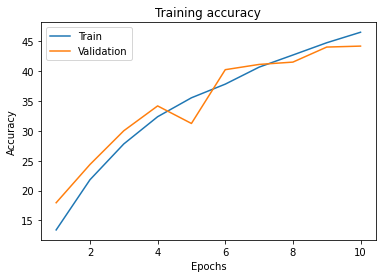

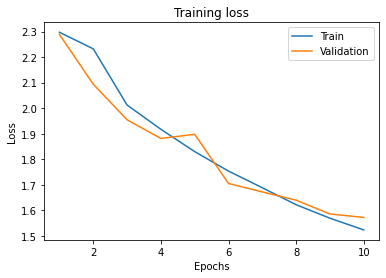

Exactitude en test: 44.68


In [16]:
model = CifarNet()
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=lr)
history_sgd = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)
history_sgd.display_accuracy()
history_sgd.display_loss()
print('Exactitude en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

Complétez cette cellule pour entraîner avec SGD + Momentum accéléré de Nesterov. Utilisez un momentum de 0.9.

Epoch: 1/10 Step: 313/313 100.00% |█████████████████████████|5.92s loss: 1.905496 acc: 31.582500 val_loss: 1.727843 val_acc: 37.670000
Epoch: 2/10 Step: 313/313 100.00% |█████████████████████████|5.89s loss: 1.423257 acc: 49.680000 val_loss: 1.379060 val_acc: 51.490000
Epoch: 3/10 Step: 313/313 100.00% |█████████████████████████|5.87s loss: 1.244393 acc: 55.960000 val_loss: 1.221438 val_acc: 57.460000
Epoch: 4/10 Step: 313/313 100.00% |█████████████████████████|5.83s loss: 1.112675 acc: 61.320000 val_loss: 1.133840 val_acc: 59.970000
Epoch: 5/10 Step: 313/313 100.00% |█████████████████████████|5.91s loss: 0.998697 acc: 65.187500 val_loss: 1.063967 val_acc: 63.060000
Epoch: 6/10 Step: 313/313 100.00% |█████████████████████████|5.85s loss: 0.905340 acc: 68.780000 val_loss: 0.973055 val_acc: 66.240000
Epoch: 7/10 Step: 313/313 100.00% |█████████████████████████|5.82s loss: 0.823170 acc: 71.720000 val_loss: 0.941142 val_acc: 67.610000
Epoch: 8/10 Step: 313/313 100.00% |████████████████████

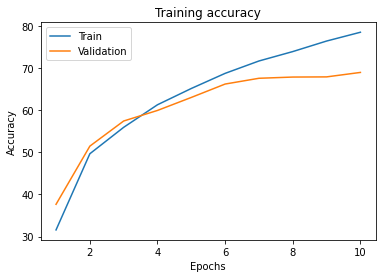

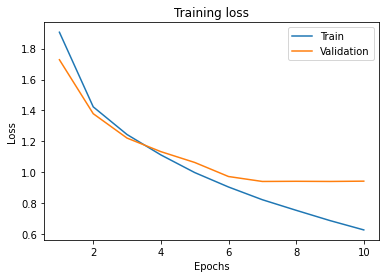

Exactitude en test: 68.86


In [17]:
model = CifarNet()
model.cuda()
#optimizer =
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
history_SGDMN = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)
history_SGDMN.display_accuracy()
history_SGDMN.display_loss()
print('Exactitude en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

Complétez cette cellule pour entraîner avec Adam

Epoch: 1/10 Step: 313/313 100.00% |█████████████████████████|5.81s loss: 2.003287 acc: 26.660000 val_loss: 1.775742 val_acc: 34.570000
Epoch: 2/10 Step: 313/313 100.00% |█████████████████████████|5.80s loss: 1.664107 acc: 40.030000 val_loss: 1.585648 val_acc: 42.520000
Epoch: 3/10 Step: 313/313 100.00% |█████████████████████████|5.77s loss: 1.571043 acc: 43.587500 val_loss: 1.574730 val_acc: 42.670000
Epoch: 4/10 Step: 313/313 100.00% |█████████████████████████|5.77s loss: 1.511963 acc: 45.865000 val_loss: 1.527048 val_acc: 44.800000
Epoch: 5/10 Step: 313/313 100.00% |█████████████████████████|5.79s loss: 1.478335 acc: 47.240000 val_loss: 1.500295 val_acc: 46.370000
Epoch: 6/10 Step: 313/313 100.00% |█████████████████████████|5.82s loss: 1.443783 acc: 48.110000 val_loss: 1.493552 val_acc: 46.600000
Epoch: 7/10 Step: 313/313 100.00% |█████████████████████████|5.78s loss: 1.416922 acc: 49.377500 val_loss: 1.462083 val_acc: 48.030000
Epoch: 8/10 Step: 313/313 100.00% |████████████████████

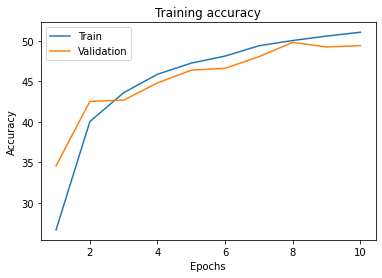

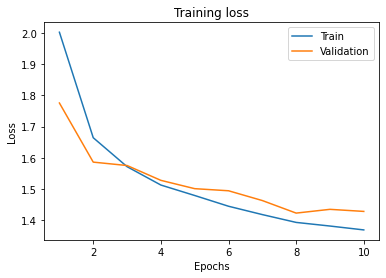

Exactitude en test: 48.76


In [18]:
model = CifarNet()
model.cuda()
#optimizer =
optimizer = optim.Adam(model.parameters(), lr=lr)
history_adam = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)
history_adam.display_accuracy()
history_adam.display_loss()
print('Exactitude en test: {:.2f}'.format(test(model, cifar_test, batch_size)))

#### Questions
- Quelle méthode semble être la meilleure dans ce cas-ci? **Les résultats peuvent varier en fonction de l'initialisation. Dans ce solutionnaire, on remarque que l'exactitude en validation et en test de SGD + Momentum accéléré de Nesterov est la meilleur suivies de Adam qui est très proche de SGD seul.**
- Remarquez-vous une différence d'overfitting? **On remarque une grande différence entre les perte d'entraînement et de validation pour SGD + Momentum accéléré de Nesterov alors que la différence est quasiment nulle pour SGD alors que Adam est entre les deux. Encore une fois, les résultats peuvent varier en fonction de l'initialisation.**

**Il est a noté que si l'on changeait l'architecture, les données, la tâche ou tout autre hyperparamètre, la performance des optimiseurs va varier.**

## 2. Horaire d'entraînement

Une pratique courante utilisé en apprentissage profonds est de faire diminuer le taux d'apprentissage pendant l'entraînement.

Pour ce faire, PyTorch fourni plusieurs fonctions (ExponentialLR, LambdaLR, MultiStepLR, etc.).  Dans ce notebook, on utilisera les [callbacks correspondant de Poutyne](https://poutyne.org/callbacks.html#lr-schedulers) qui cachent sous le capot les fonctions de PyTorch.

Voici un exemple avec ExponentialLR.

In [19]:
model = CifarNet()
model.cuda()

batch_size = 128
lr = 0.01
n_epoch = 10

optimizer = optim.SGD(model.parameters(), lr=lr)

gamma = 0.99
scheduler = pt.ExponentialLR(gamma)

history = train(model, optimizer, cifar_train, n_epoch, batch_size, callbacks=[scheduler], use_gpu=True)

Epoch: 1/10 Step: 313/313 100.00% |█████████████████████████|5.79s loss: 2.270530 acc: 15.347500 val_loss: 2.184079 val_acc: 23.470000
Epoch: 2/10 Step: 313/313 100.00% |█████████████████████████|5.71s loss: 2.052614 acc: 25.682500 val_loss: 1.989127 val_acc: 29.350000
Epoch: 3/10 Step: 313/313 100.00% |█████████████████████████|5.80s loss: 1.965559 acc: 29.127500 val_loss: 1.930527 val_acc: 31.860000
Epoch: 4/10 Step: 313/313 100.00% |█████████████████████████|5.74s loss: 1.898840 acc: 33.062500 val_loss: 1.830734 val_acc: 36.200000
Epoch: 5/10 Step: 313/313 100.00% |█████████████████████████|5.75s loss: 1.800731 acc: 36.722500 val_loss: 1.776671 val_acc: 36.400000
Epoch: 6/10 Step: 313/313 100.00% |█████████████████████████|5.72s loss: 1.717489 acc: 39.370000 val_loss: 1.671131 val_acc: 41.340000
Epoch: 7/10 Step: 313/313 100.00% |█████████████████████████|5.79s loss: 1.646446 acc: 42.072500 val_loss: 1.617347 val_acc: 43.300000
Epoch: 8/10 Step: 313/313 100.00% |████████████████████

Affichons la valeur du taux d'apprentissage.

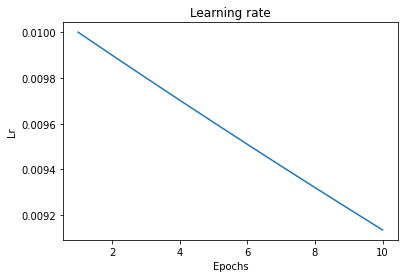

In [20]:
history.display_lr()

#### Exercice

Utilisez [MultiStepLR](http://pytorch.org/docs/master/optim.html#torch.optim.lr_scheduler.MultiStepLR) pour modifier le taux d'apprentissage pour un epoch précis.

1. Commencez avec un taux d'apprentissage trop élevé pour que le réseau puisse apprendre quelque chose.
2. Diminuez le progressivement jusqu'à ce que le réseau apprenne.
3. Trouvez le moment où la validation semble avoir atteint un plateau.
4. Diminuez le taux par 2 à ce moment et réentraîner le réseau.

In [21]:
torch.manual_seed(42)
model = CifarNet()
model.cuda()

#epoch_list = []
epoch_list = [8, 11, 12]

batch_size = 128
#lr = 10
lr = 0.5
n_epoch = 20

optimizer = optim.SGD(model.parameters(), lr=lr)
scheduler = pt.MultiStepLR(milestones=epoch_list, gamma=0.5, verbose=True)

history = train(model, optimizer, cifar_train, n_epoch, batch_size, callbacks=[scheduler], use_gpu=True)

Adjusting learning rate of group 0 to 5.0000e-01.
Epoch: 1/20 Step: 313/313 100.00% |█████████████████████████|5.81s loss: 2.165752 acc: 19.697500 val_loss: 1.881173 val_acc: 31.330000
Adjusting learning rate of group 0 to 5.0000e-01.
Epoch: 2/20 Step: 313/313 100.00% |█████████████████████████|5.80s loss: 1.723739 acc: 37.957500 val_loss: 1.679807 val_acc: 40.450000
Adjusting learning rate of group 0 to 5.0000e-01.
Epoch: 3/20 Step: 313/313 100.00% |█████████████████████████|5.74s loss: 1.468319 acc: 47.760000 val_loss: 1.638092 val_acc: 42.570000
Adjusting learning rate of group 0 to 5.0000e-01.
Epoch: 4/20 Step: 313/313 100.00% |█████████████████████████|5.80s loss: 1.316126 acc: 53.425000 val_loss: 1.427531 val_acc: 51.720000
Adjusting learning rate of group 0 to 5.0000e-01.
Epoch: 5/20 Step: 313/313 100.00% |█████████████████████████|5.74s loss: 1.222300 acc: 56.990000 val_loss: 1.240246 val_acc: 56.730000
Adjusting learning rate of group 0 to 5.0000e-01.
Epoch: 6/20 Step: 313/313

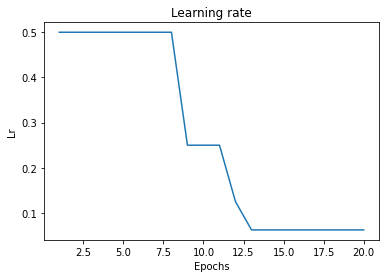

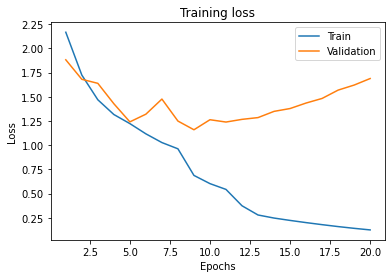

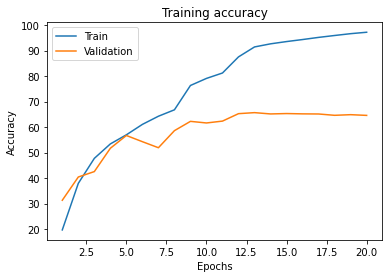

In [22]:
history.display_lr()
history.display_loss()
history.display_accuracy()

#### Questions
- Voyez-vous une différence en diminuant le taux d'apprentissage par 2 après x epochs? **Dans l'exécution de ce solutionnaire, on peut voir une diminution significative de la perte en entraînement ainsi qu'une augmentation significative de l'exactitude en entraînement lorsque l'on diminue le taux d'apprentissage à des moments clés. On peut faire un constat similaire pour la validation mais dans une moindre mesure.**
- Pourquoi? **Réduire le taux d'apprentissage du réseau de neurone lorsque l'apprentissage stagne permet à l'optimisation de se concentrer plus spécifiquement sur l'espace de paramètres actuel qui est relativement bon au lieu de continuer à visiter l'espace de manière plus large. Dans le jargon. on peut dire que l'on vient faire une exploitation plus locale. C'est donc normalement d'obtenir une légère amélioration au niveau des métriques.**

### Pour aller plus loin

On vient de faire "à la main" ce que la classe [ReduceLROnPlateau](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau) de PyTorch nous permet de faire automatiquement. Essentiellement, cette classe nous permet de monitorer une métrique et de réduire le taux d'apprentissage lorsque cette métrique stagne pour un certain nombre d'epochs. Ce nombre d'epoch est appelé la "patience". Nous allons utilisez le callback [poutyne.ReduceLROnPlateau](https://poutyne.org/callbacks.html#poutyne.ReduceLROnPlateau) de Poutyne qui prend en paramètre le nom de la métrique à monitorer en plus des autres arguments de la classe de PyTorch.

Notez bien la description du paramètre `patience` dans la documentation de PyTorch:
> **patience** - Number of epochs with no improvement after which learning rate will be reduced. For example, if patience = 2, then we will ignore the first 2 epochs with no improvement, and will only decrease the LR after the 3rd epoch if the loss still hasn’t improved then.

Dans la cellule ci-dessous, on monitore l'exactitude en validation avec une patience de 1 epoch.

In [39]:
model = CifarNet()
model.cuda()

batch_size = 128
lr = 0.5
n_epoch = 20

optimizer = optim.SGD(model.parameters(), lr=lr)
scheduler = pt.ReduceLROnPlateau(monitor='val_acc', mode='max', patience=1, factor=0.5, verbose=True)

history = train(model, optimizer, cifar_train, n_epoch, batch_size, callbacks=[scheduler], use_gpu=True)

Epoch: 1/20 Step: 313/313 100.00% |█████████████████████████|5.75s loss: 2.093488 acc: 23.215000 val_loss: 1.824516 val_acc: 33.250000
Epoch: 2/20 Step: 313/313 100.00% |█████████████████████████|5.74s loss: 1.720654 acc: 38.515000 val_loss: 1.684952 val_acc: 39.720000
Epoch: 3/20 Step: 313/313 100.00% |█████████████████████████|5.83s loss: 1.494594 acc: 47.042500 val_loss: 1.505988 val_acc: 48.140000
Epoch: 4/20 Step: 313/313 100.00% |█████████████████████████|5.79s loss: 1.346015 acc: 52.595000 val_loss: 1.384739 val_acc: 51.720000
Epoch: 5/20 Step: 313/313 100.00% |█████████████████████████|5.78s loss: 1.235390 acc: 56.732500 val_loss: 1.686698 val_acc: 45.360000
Epoch: 6/20 Step: 313/313 100.00% |█████████████████████████|5.81s loss: 1.134321 acc: 60.370000 val_loss: 1.458926 val_acc: 51.020000
Epoch     6: reducing learning rate of group 0 to 2.5000e-01.
Epoch: 7/20 Step: 313/313 100.00% |█████████████████████████|5.80s loss: 0.864644 acc: 69.745000 val_loss: 1.159514 val_acc: 61.

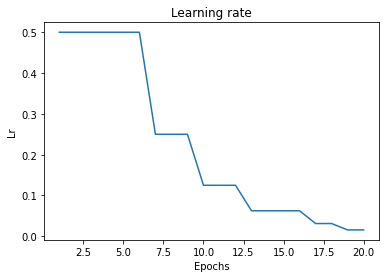

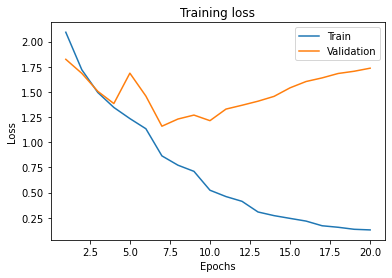

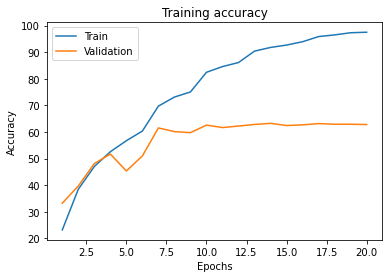

In [40]:
history.display_lr()
history.display_loss()
history.display_accuracy()

## 3. Batch Normalization

Voici l'architecture du réseau de neurones convolutionnels que vous avez utilisé jusqu'à présent pour faire de la classification sur Cifar10.

In [23]:
import torch.nn.functional as F

class CifarNetBatchNorm(nn.Module):
    def __init__(self):
        super(CifarNetBatchNorm, self).__init__()
        #self.conv1 = nn.Conv2d(3, 10, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(10)
        #self.conv2 = nn.Conv2d(10, 50, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(50)
        #self.conv3 = nn.Conv2d(50, 150, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(150)
        self.fc1 = nn.Linear(150 * 8 * 8, 10)

    def forward(self, x):
        #x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), (2, 2))
        #x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        #x = F.relu(self.conv3(x))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        return x

    @staticmethod
    def num_flat_features(x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

#### Exercice

- Modifier l'architecture du réseau en ajoutant de la batch normalization entre les couches de convolutions et les ReLUs (essentiellement, on devait avoir `Conv2d -> BatchNorm2d -> ReLU`) et entraîner le nouveau réseau.

Epoch: 1/10 Step: 313/313 100.00% |█████████████████████████|6.07s loss: 1.512767 acc: 46.485000 val_loss: 1.977861 val_acc: 36.270000
Epoch: 2/10 Step: 313/313 100.00% |█████████████████████████|6.04s loss: 1.130908 acc: 60.062500 val_loss: 1.342215 val_acc: 51.610000
Epoch: 3/10 Step: 313/313 100.00% |█████████████████████████|6.12s loss: 0.982461 acc: 65.697500 val_loss: 1.123135 val_acc: 60.710000
Epoch: 4/10 Step: 313/313 100.00% |█████████████████████████|6.12s loss: 0.884188 acc: 69.410000 val_loss: 1.157141 val_acc: 60.230000
Epoch: 5/10 Step: 313/313 100.00% |█████████████████████████|6.03s loss: 0.814533 acc: 71.927500 val_loss: 1.150723 val_acc: 59.530000
Epoch: 6/10 Step: 313/313 100.00% |█████████████████████████|6.07s loss: 0.754137 acc: 74.150000 val_loss: 1.047055 val_acc: 63.450000
Epoch: 7/10 Step: 313/313 100.00% |█████████████████████████|6.06s loss: 0.702977 acc: 76.135000 val_loss: 1.049825 val_acc: 63.550000
Epoch: 8/10 Step: 313/313 100.00% |████████████████████

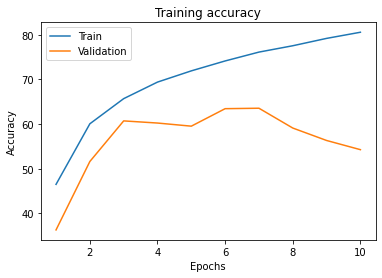

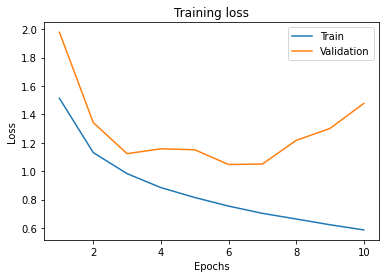

In [36]:
model = CifarNetBatchNorm()
model.cuda()

lr = 0.01
batch_size = 128
n_epoch = 10

optimizer = optim.SGD(model.parameters(), lr=lr)

history = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)
history.display_accuracy()
history.display_loss()

#### Questions

- Comparer l'entraînement du réseau avec et sans la batch normalization (Section 1.2 avec SGD (où on a entraîné le réseau sans batch normalization avec le même taux d'apprentissage). Que remarquez-vous? **On remarque une amélioration des résultats ainsi qu'un sur-apprentissage plus grand.**

### Effet de la batch normalization sur le taux d'apprentissage

Commençons par entraîner un réseau avec un taux d'apprentissage élevé.

In [25]:
lr = 0.5
batch_size = 1024
n_epoch = 10

In [26]:
model = CifarNet()
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=lr)

history = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)

Epoch: 1/10 Step: 40/40 100.00% |█████████████████████████|5.20s loss: 2.329972 acc: 11.892500 val_loss: 2.302296 val_acc: 10.680000
Epoch: 2/10 Step: 40/40 100.00% |█████████████████████████|5.17s loss: 2.273136 acc: 14.262500 val_loss: 2.264929 val_acc: 19.600000
Epoch: 3/10 Step: 40/40 100.00% |█████████████████████████|5.22s loss: 2.142845 acc: 22.157500 val_loss: 2.383740 val_acc: 18.480000
Epoch: 4/10 Step: 40/40 100.00% |█████████████████████████|5.14s loss: 2.035800 acc: 27.362500 val_loss: 2.097070 val_acc: 27.280000
Epoch: 5/10 Step: 40/40 100.00% |█████████████████████████|5.14s loss: 1.899199 acc: 32.137500 val_loss: 1.901955 val_acc: 32.420000
Epoch: 6/10 Step: 40/40 100.00% |█████████████████████████|5.12s loss: 1.803224 acc: 35.370000 val_loss: 1.923327 val_acc: 28.880000
Epoch: 7/10 Step: 40/40 100.00% |█████████████████████████|5.05s loss: 1.733065 acc: 38.252500 val_loss: 1.905250 val_acc: 33.210000
Epoch: 8/10 Step: 40/40 100.00% |█████████████████████████|5.15s loss

Essayons maintenant d'entraîner le réseau utilisant la batch normalization avec les mêmes hyperparamètres.

In [27]:
model = CifarNetBatchNorm()
model.cuda()
optimizer = optim.SGD(model.parameters(), lr=lr)

history = train(model, optimizer, cifar_train, n_epoch, batch_size, use_gpu=True)

Epoch: 1/10 Step: 40/40 100.00% |█████████████████████████|5.25s loss: 5.279550 acc: 15.277500 val_loss: 2.209719 val_acc: 20.050000
Epoch: 2/10 Step: 40/40 100.00% |█████████████████████████|5.33s loss: 1.968423 acc: 28.257500 val_loss: 2.632465 val_acc: 16.810000
Epoch: 3/10 Step: 40/40 100.00% |█████████████████████████|5.24s loss: 1.756867 acc: 36.255000 val_loss: 2.606951 val_acc: 22.160000
Epoch: 4/10 Step: 40/40 100.00% |█████████████████████████|5.24s loss: 1.640406 acc: 40.805000 val_loss: 3.053111 val_acc: 20.080000
Epoch: 5/10 Step: 40/40 100.00% |█████████████████████████|5.29s loss: 1.539834 acc: 44.697500 val_loss: 2.751534 val_acc: 25.640000
Epoch: 6/10 Step: 40/40 100.00% |█████████████████████████|5.24s loss: 1.498827 acc: 46.430000 val_loss: 2.236587 val_acc: 32.230000
Epoch: 7/10 Step: 40/40 100.00% |█████████████████████████|5.31s loss: 1.465838 acc: 47.962500 val_loss: 1.745500 val_acc: 42.090000
Epoch: 8/10 Step: 40/40 100.00% |█████████████████████████|5.34s loss

#### Questions
- Que pouvez-vous conclure sur l'effet de la batch normalization sur le taux d'apprentissage? **Les résultats peuvent varier mais, généralement parlant, la batch normalization permet d'apprendre avec un taux d'apprentissage plus élevé et d'y être plus résilient.**

### Analyse

Après l'entraînement, il est important d'analyser les résultats obtenus.
Commençons par tester le réseau en utilisant la fonction `validate_ranking`.
Cette fonction sépare les résultats bien classés des erreurs et retourne pour chaque image, un score (qu'on peut voir comme une probabilité), la vraie classe et la classe prédite.

In [28]:
good, errors = validate_ranking(model, cifar_test, batch_size, use_gpu=True)

Maintenant, regardons quelques exemples d'images bien classés.

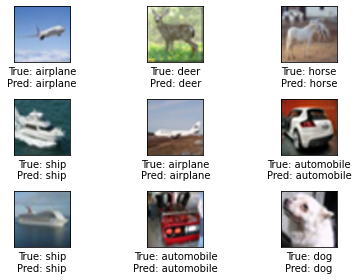

In [29]:
show_random(good)

Et quelques exemples mal classés.

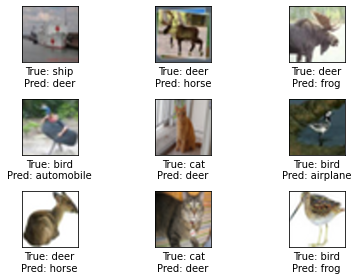

In [30]:
show_random(errors)

Il est aussi possible de regarder les exemples où le réseau est le plus confiant.

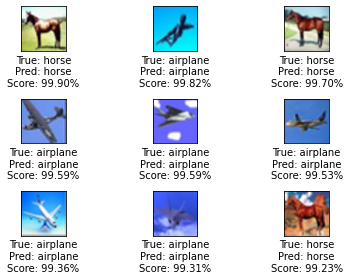

In [31]:
show_best(good)

Ou l'inverse, ceux qui ont obtenus les moins bons scores.

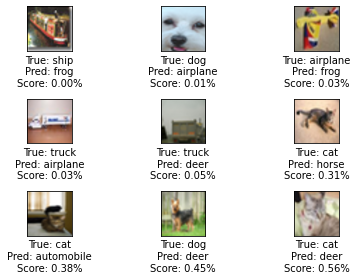

In [32]:
show_worst(errors)

Finalement, il peut être intéressant de regarder les exemples les plus difficiles.
Soit ceux qui ont été bien classés, mais qui ont eu un mauvais score.

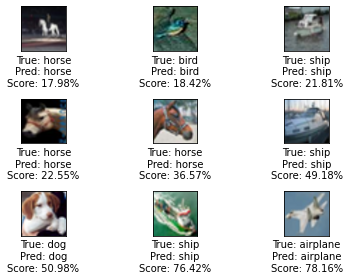

In [33]:
show_worst(good)

Ou ceux qui ont été mal classés, mais qui ont quand même réussi à obtenir un bon score.

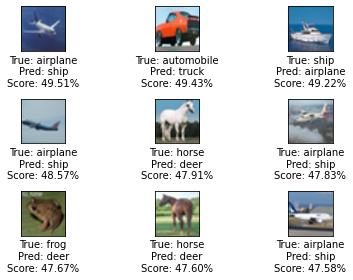

In [34]:
show_best(errors)

#### Questions 
- En observant les résultats obtenus, que pouvez-vous dire sur les performances du réseau? **La réponse à cette question va vraiment dépendre du minimum local qui a été atteint par le réseau. C'est possible que le réseau ait très bien appris certaines classes mais que d'autres aient été délaissées.**
- Quelle classe semble être facile? Pourquoi? **Dans l'exécution de ce solutionnaire, il semble que le réseau s'est concentré sur les avions. La présence des ailes d'un avion en plus du ciel aide probablement le réseau à faire sa tâche.**
- Quelle classe semble être difficile? Pourquoi? **Dans l'exécution de ce solutionnaire, il semble que le réseau a beaucoup de difficulté à différencier les avions des bateaux. Ceci est probablement dû au fait que l'arrière plan des deux classes est souvent bleu comme le ciel et la mer.**